# Slime Mold Spatio-Temporal Prediction

## Project Overview
This notebook implements models to predict aggregation centers of *Dictyostelium discoideum* cells from microscopy time-lapse movies. The goal is to predict where cells will aggregate using early frames of the movie.

## Key Requirements
- **Multiple Experiments**: Train and evaluate separately on each of the three experimental datasets
- **Metrics**: Report mean ± CI (confidence interval) from multiple training runs on the same data
- **Robustness**: Test generalization across experiments
- **Visualization**: Overlay predicted hotspots/centers on early frames with confidence maps
- **Modeling**: Use any appropriate approach (probabilistic, clustering, deep learning, etc.) with proper justification

## Available Datasets
- `mixin_test44`: 2024-01-17 experiment
- `mixin_test57`: 2024-02-29 experiment  
- `mixin_test64`: 2024-04-04 experiment

Each dataset contains zarr format time-lapse stacks showing cell movement and aggregation patterns.

In [ ]:
# Setup (optional installs)
# Uncomment the line below if you need to install packages
# !pip install tifffile h5py scikit-image tqdm zarr numcodecs


In [ ]:
# Imports & seed
import os, random, numpy as np, matplotlib.pyplot as plt, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

# Try importing optional packages
try:
    import tifffile as tiff
except Exception:
    tiff = None
try:
    import h5py
except Exception:
    h5py = None
try:
    import zarr
except Exception:
    zarr = None

def set_seed(seed=7):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(7)
print(f"Using device: {DEVICE}")


'cpu'

## 1) Load data (choose a reader and set `DATA_PATH`)

In [ ]:
# Data readers
# According to project requirements:
# - Use ORIGINAL zarr files for TRAINING
# - Use SUBSAMPLED zarr files for EVALUATION/EXPERIMENTATION
# 
# Available experimental datasets:
# - mixin_test44: Original and subsampled versions available
# - mixin_test57: Original and subsampled versions available
# - mixin_test64: Original and subsampled versions available

# Set the experiment name here
# Change this to analyze different experiments
EXPERIMENT_NAME = "mixin_test57"  # Options: "mixin_test44", "mixin_test57", "mixin_test64"

# Construct paths based on experiment name
# ORIGINAL files for training (higher resolution, more frames)
if EXPERIMENT_NAME == "mixin_test44":
    TRAIN_DATA_PATH = "data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed.zarr"
    EVAL_DATA_PATH = "data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr"
elif EXPERIMENT_NAME == "mixin_test57":
    TRAIN_DATA_PATH = "data/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25.zarr"
    EVAL_DATA_PATH = "data/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled.zarr"
elif EXPERIMENT_NAME == "mixin_test64":
    TRAIN_DATA_PATH = "data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1.zarr"
    EVAL_DATA_PATH = "data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled.zarr"
else:
    TRAIN_DATA_PATH = None
    EVAL_DATA_PATH = None
    print(f"Unknown experiment: {EXPERIMENT_NAME}")

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Training data (original): {TRAIN_DATA_PATH}")
print(f"Evaluation data (subsampled): {EVAL_DATA_PATH}")

def read_npy(path):
    """Read numpy array from .npy file"""
    return np.load(path)

def read_h5(path, key="images"):
    """Read data from HDF5 file"""
    assert h5py is not None, "install h5py: pip install h5py"
    import h5py as _h5
    with _h5.File(path, "r") as f:
        arr = f[key][:]
    return np.array(arr)

def read_tiff_stack(path):
    """Read TIFF image stack"""
    assert tiff is not None, "install tifffile: pip install tifffile"
    return np.asarray(tiff.imread(path))

def read_zarr(path):
    """Read zarr array from directory or file"""
    assert zarr is not None, "install zarr: pip install zarr numcodecs"
    # Open zarr array (works for both directory and file formats)
    z = zarr.open(path, mode='r')
    # Convert to numpy array
    arr = np.array(z)
    return arr

def load_data(path, data_type="unknown"):
    """Load data from a given path, handling different file formats"""
    if path is None or not os.path.exists(path):
        return None
    
    try:
        if path.endswith('.zarr') or os.path.isdir(path):
            print(f"Loading zarr {data_type} data from: {path}")
            arr = read_zarr(path)
            print(f"Successfully loaded {data_type} zarr data with shape: {arr.shape}")
            return arr
        elif path.endswith('.npy'):
            print(f"Loading numpy {data_type} data from: {path}")
            return read_npy(path)
        elif path.endswith('.h5') or path.endswith('.hdf5'):
            print(f"Loading HDF5 {data_type} data from: {path}")
            return read_h5(path, key="images")
        elif path.endswith('.tif') or path.endswith('.tiff'):
            print(f"Loading TIFF {data_type} data from: {path}")
            return read_tiff_stack(path)
        else:
            print(f"Unknown file format for: {path}")
            return None
    except Exception as e:
        print(f"Error loading {data_type} data from {path}: {e}")
        return None

# Load training data (original, higher resolution)
raw_train = load_data(TRAIN_DATA_PATH, "training")

# Load evaluation data (subsampled, for testing/experimentation)
raw_eval = load_data(EVAL_DATA_PATH, "evaluation")

# If training data loading failed, use synthetic placeholder
if raw_train is None:
    print("Training data not available. Using synthetic demo data...")
    def synthetic_demo(T=60, H=64, W=64):
        """Generate synthetic time-lapse data for testing"""
        x = np.zeros((T, H, W), np.float32)
        for t in range(T):
            cx = int(H/2 + (10+5*np.sin(t/8))*np.cos(t/10))
            cy = int(W/2 + (10+5*np.sin(t/8))*np.sin(t/10))
            x[t, cx%H, cy%W] = 1.0
            x[t] = np.clip(x[t] + 0.1*np.random.randn(H, W).astype(np.float32), 0, 1)
        return x
    raw_train = synthetic_demo()

# Use training data as the main dataset for model development
raw = raw_train

# Print data information
print("\n" + "="*60)
print("TRAINING DATA (Original):")
print(f"  Shape: {raw_train.shape}")
print(f"  Dtype: {raw_train.dtype}")
print(f"  Range: [{raw_train.min():.4f}, {raw_train.max():.4f}]")

if raw_eval is not None:
    print("\nEVALUATION DATA (Subsampled):")
    print(f"  Shape: {raw_eval.shape}")
    print(f"  Dtype: {raw_eval.dtype}")
    print(f"  Range: [{raw_eval.min():.4f}, {raw_eval.max():.4f}]")
else:
    print("\nEVALUATION DATA: Not loaded (will use training data for evaluation)")
print("="*60)

(60, 64, 64)

shape: (60, 64, 64) min/max: 0.0 1.0


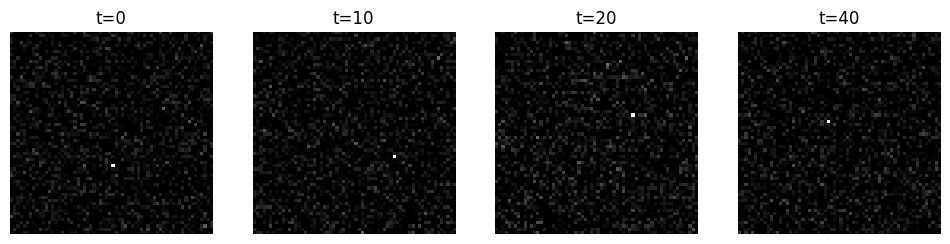

In [ ]:
# Inspect & visualize a few frames
print("Data shape:", raw.shape)
print("Data min/max:", float(raw.min()), float(raw.max()))

def show_frames(arr, frames=(0, 10, 20, 40)):
    """Visualize selected frames from the time-lapse data"""
    fig, axs = plt.subplots(1, len(frames), figsize=(12, 3))
    for ax, t in zip(axs, frames):
        # Handle both 3D (T, H, W) and 4D (T, C, H, W) arrays
        frame = arr[t] if arr.ndim == 3 else arr[t, 0]
        ax.imshow(frame, cmap="gray")
        ax.set_title(f"t={t}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Show a few sample frames to understand the data
show_frames(raw)

## 2) Dataset/Dataloader (sliding window next-frame prediction)

In [ ]:
# Dataset & loaders
# This creates a sliding window dataset for next-frame prediction
# K frames are used as input to predict the (K+1)th frame

class WindowedFrames(Dataset):
    """Dataset that creates sliding windows of K frames to predict the next frame"""
    def __init__(self, arr, K=4):
        # Add channel dimension if needed (expects 3D: T, H, W)
        if arr.ndim == 3:
            arr = arr[:, None, ...]  # Add channel dimension: (T, 1, H, W)
        self.arr = arr.astype(np.float32)
        self.K = K
    
    def __len__(self):
        return self.arr.shape[0] - self.K
    
    def __getitem__(self, i):
        # Input: K consecutive frames
        x = torch.from_numpy(self.arr[i:i+self.K])  # (K, 1, H, W)
        # Target: the next frame after the K frames
        y = torch.from_numpy(self.arr[i+self.K])    # (1, H, W)
        return x, y

# Create dataset with K=4 frames as input
K = 4
ds = WindowedFrames(raw, K)

# Split into train/validation/test sets (70/15/15)
n_tr = int(0.7 * len(ds))
n_val = int(0.15 * len(ds))
n_te = len(ds) - n_tr - n_val

tr, val, te = random_split(ds, [n_tr, n_val, n_te], 
                          generator=torch.Generator().manual_seed(0))

# Create data loaders
tr_loader = DataLoader(tr, batch_size=16, shuffle=True)
val_loader = DataLoader(val, batch_size=32, shuffle=False)
te_loader = DataLoader(te, batch_size=32, shuffle=False)

print(f"Dataset sizes - Train: {len(tr)}, Val: {len(val)}, Test: {len(te)}")

(39, 8, 9)

## 3) Baseline model (Conv3D encoder → Conv2D head)

ep 05  tr 0.0187  val 0.0160
ep 10  tr 0.0048  val 0.0041
ep 15  tr 0.0042  val 0.0041
ep 20  tr 0.0037  val 0.0038


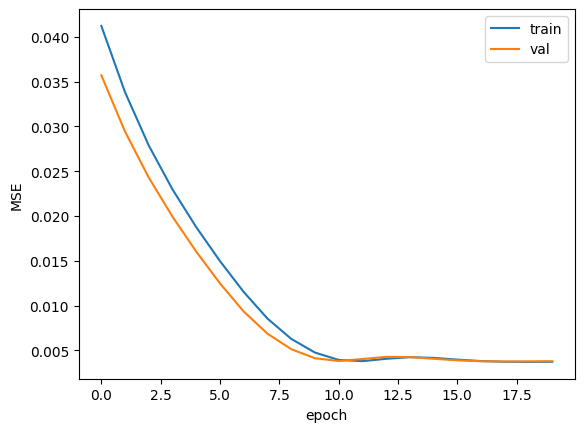

In [ ]:
# Model, train, eval
# Baseline model: Conv3D encoder to process temporal sequence, then Conv2D head for prediction

class TinyCNN(nn.Module):
    """Simple CNN for next-frame prediction using K input frames"""
    def __init__(self, K):
        super().__init__()
        # Conv3D encoder: processes K frames together
        # kernel_size=(K,3,3) means it processes all K frames in time dimension
        self.enc = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(K, 3, 3), padding=(0, 1, 1)),
            nn.ReLU()
        )
        # Conv2D head: processes the encoded spatial features
        self.head = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 1)  # Output single channel frame
        )
    
    def forward(self, x):
        # Input: (B, K, 1, H, W) -> permute to (B, 1, K, H, W) for Conv3D
        x = x.permute(0, 2, 1, 3, 4)
        # Encoder: (B, 1, K, H, W) -> (B, 8, 1, H, W) -> squeeze -> (B, 8, H, W)
        z = self.enc(x).squeeze(2)
        # Head: (B, 8, H, W) -> (B, 1, H, W)
        return self.head(z)

# Initialize model and optimizer
model = TinyCNN(K).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

def train_epoch(model, loader):
    """Train for one epoch"""
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    """Evaluate model on a dataset"""
    model.eval()
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        total += loss_fn(model(xb), yb).item() * xb.size(0)
    return total / len(loader.dataset)

# Training loop
hist_tr, hist_val = [], []
for ep in range(1, 21):
    tr = train_epoch(model, tr_loader)
    va = evaluate(model, val_loader)
    hist_tr.append(tr)
    hist_val.append(va)
    if ep % 5 == 0:
        print(f"Epoch {ep:02d}  Train: {tr:.4f}  Val: {va:.4f}")

# Plot training curves
plt.figure()
plt.plot(hist_tr, label="train")
plt.plot(hist_val, label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("Training and Validation Loss")
plt.show()

## 4) Qualitative prediction

## 4.5) Evaluate on Subsampled Data

After training on the original data, evaluate the model on the subsampled evaluation data to test robustness and generalization.


In [ ]:
# Evaluate trained model on subsampled evaluation data
# This tests how well the model generalizes to different temporal sampling

if raw_eval is not None:
    print("Evaluating model on subsampled evaluation data...")
    
    # Create evaluation dataset from subsampled data
    ds_eval = WindowedFrames(raw_eval, K)
    eval_loader = DataLoader(ds_eval, batch_size=32, shuffle=False)
    
    # Evaluate model on subsampled data
    eval_loss = evaluate(model, eval_loader)
    print(f"\nEvaluation on subsampled data:")
    print(f"  MSE Loss: {eval_loss:.4f}")
    print(f"  Number of samples: {len(ds_eval)}")
    print(f"  Data shape: {raw_eval.shape}")
    
    # Compare with validation loss on training data
    val_loss_train_data = evaluate(model, val_loader)
    print(f"\nComparison:")
    print(f"  Validation loss (original training data): {val_loss_train_data:.4f}")
    print(f"  Evaluation loss (subsampled data): {eval_loss:.4f}")
    print(f"  Difference: {abs(eval_loss - val_loss_train_data):.4f}")
    
    # Show example prediction on evaluation data
    print("\nShowing example prediction on evaluation data:")
    @torch.no_grad()
    def show_eval_example(i=0):
        """Visualize prediction on evaluation data"""
        xb, yb = ds_eval[i]
        pred = model(xb.unsqueeze(0).to(DEVICE)).cpu().squeeze().numpy()
        true = yb.squeeze().numpy()
        hist = xb[:, 0].numpy()
        
        cols = hist.shape[0] + 2
        fig, axs = plt.subplots(1, cols, figsize=(3*cols, 3))
        
        for k in range(hist.shape[0]):
            axs[k].imshow(hist[k], cmap="gray")
            axs[k].set_title(f"t-{hist.shape[0]-k}")
            axs[k].axis("off")
        
        axs[-2].imshow(true, cmap="gray")
        axs[-2].set_title("True")
        axs[-2].axis("off")
        
        axs[-1].imshow(pred, cmap="gray")
        axs[-1].set_title("Pred")
        axs[-1].axis("off")
        
        plt.tight_layout()
        plt.show()
    
    show_eval_example(5)
else:
    print("Evaluation data (subsampled) not available. Skipping evaluation on subsampled data.")


## 6) Automated Experiment Runner

This section automates running experiments across all three datasets. It trains models separately on each experiment and evaluates them, collecting metrics for comparison.


In [ ]:
# Automated experiment runner
# This function runs training and evaluation on all three experiments
# and collects metrics for comparison

def run_experiment(experiment_name, num_runs=3, epochs=20, K=4):
    """
    Run training and evaluation for a single experiment multiple times
    
    Parameters:
    -----------
    experiment_name : str
        Name of the experiment ("mixin_test44", "mixin_test57", or "mixin_test64")
    num_runs : int
        Number of training runs with different seeds (for CI calculation)
    epochs : int
        Number of training epochs
    K : int
        Number of input frames for prediction
    
    Returns:
    --------
    results : dict
        Dictionary containing all metrics and results
    """
    print(f"\n{'='*80}")
    print(f"Running experiment: {experiment_name}")
    print(f"{'='*80}")
    
    # Set up paths for this experiment
    if experiment_name == "mixin_test44":
        train_path = "data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed.zarr"
        eval_path = "data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr"
    elif experiment_name == "mixin_test57":
        train_path = "data/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25.zarr"
        eval_path = "data/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled.zarr"
    elif experiment_name == "mixin_test64":
        train_path = "data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1.zarr"
        eval_path = "data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled.zarr"
    else:
        raise ValueError(f"Unknown experiment: {experiment_name}")
    
    # Load data
    raw_train = load_data(train_path, "training")
    raw_eval = load_data(eval_path, "evaluation")
    
    if raw_train is None:
        print(f"Warning: Could not load training data for {experiment_name}")
        return None
    
    # Store results from all runs
    all_train_losses = []
    all_val_losses = []
    all_test_losses = []
    all_eval_losses = []
    
    # Run multiple times with different seeds
    for run_idx in range(num_runs):
        print(f"\n--- Run {run_idx + 1}/{num_runs} ---")
        seed = 7 + run_idx * 100  # Different seed for each run
        set_seed(seed)
        
        # Create dataset and loaders
        ds = WindowedFrames(raw_train, K)
        n_tr = int(0.7 * len(ds))
        n_val = int(0.15 * len(ds))
        n_te = len(ds) - n_tr - n_val
        
        tr, val, te = random_split(ds, [n_tr, n_val, n_te], 
                                  generator=torch.Generator().manual_seed(seed))
        tr_loader = DataLoader(tr, batch_size=16, shuffle=True)
        val_loader = DataLoader(val, batch_size=32, shuffle=False)
        te_loader = DataLoader(te, batch_size=32, shuffle=False)
        
        # Initialize model
        model = TinyCNN(K).to(DEVICE)
        opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
        loss_fn = nn.MSELoss()
        
        # Training
        hist_tr, hist_val = [], []
        for ep in range(1, epochs + 1):
            tr_loss = train_epoch(model, tr_loader)
            va_loss = evaluate(model, val_loader)
            hist_tr.append(tr_loss)
            hist_val.append(va_loss)
            if ep % 5 == 0:
                print(f"  Epoch {ep:02d}  Train: {tr_loss:.4f}  Val: {va_loss:.4f}")
        
        # Final evaluation
        final_train_loss = hist_tr[-1]
        final_val_loss = hist_val[-1]
        final_test_loss = evaluate(model, te_loader)
        
        all_train_losses.append(final_train_loss)
        all_val_losses.append(final_val_loss)
        all_test_losses.append(final_test_loss)
        
        # Evaluate on subsampled data if available
        if raw_eval is not None:
            ds_eval = WindowedFrames(raw_eval, K)
            eval_loader = DataLoader(ds_eval, batch_size=32, shuffle=False)
            eval_loss = evaluate(model, eval_loader)
            all_eval_losses.append(eval_loss)
            print(f"  Test (original): {final_test_loss:.4f}, Eval (subsampled): {eval_loss:.4f}")
        else:
            print(f"  Test: {final_test_loss:.4f}")
    
    # Calculate statistics
    results = {
        'experiment': experiment_name,
        'num_runs': num_runs,
        'train_shape': raw_train.shape,
        'eval_shape': raw_eval.shape if raw_eval is not None else None,
        'train_loss': {
            'mean': np.mean(all_train_losses),
            'std': np.std(all_train_losses),
            'values': all_train_losses
        },
        'val_loss': {
            'mean': np.mean(all_val_losses),
            'std': np.std(all_val_losses),
            'values': all_val_losses
        },
        'test_loss': {
            'mean': np.mean(all_test_losses),
            'std': np.std(all_test_losses),
            'values': all_test_losses
        }
    }
    
    if all_eval_losses:
        results['eval_loss'] = {
            'mean': np.mean(all_eval_losses),
            'std': np.std(all_eval_losses),
            'values': all_eval_losses
        }
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"Summary for {experiment_name} ({num_runs} runs):")
    print(f"  Train Loss: {results['train_loss']['mean']:.4f} ± {results['train_loss']['std']:.4f}")
    print(f"  Val Loss:   {results['val_loss']['mean']:.4f} ± {results['val_loss']['std']:.4f}")
    print(f"  Test Loss:  {results['test_loss']['mean']:.4f} ± {results['test_loss']['std']:.4f}")
    if all_eval_losses:
        print(f"  Eval Loss:  {results['eval_loss']['mean']:.4f} ± {results['eval_loss']['std']:.4f}")
    print(f"{'='*80}\n")
    
    return results

# Function to run all experiments
def run_all_experiments(num_runs=3, epochs=20, K=4):
    """
    Run experiments on all three datasets
    
    Parameters:
    -----------
    num_runs : int
        Number of training runs per experiment (for CI calculation)
    epochs : int
        Number of training epochs
    K : int
        Number of input frames
    
    Returns:
    --------
    all_results : list
        List of result dictionaries for each experiment
    """
    experiments = ["mixin_test44", "mixin_test57", "mixin_test64"]
    all_results = []
    
    for exp_name in experiments:
        try:
            results = run_experiment(exp_name, num_runs=num_runs, epochs=epochs, K=K)
            if results is not None:
                all_results.append(results)
        except Exception as e:
            print(f"Error running experiment {exp_name}: {e}")
            continue
    
    return all_results

# Note: Uncomment the line below to run all experiments
# all_results = run_all_experiments(num_runs=3, epochs=20, K=4)


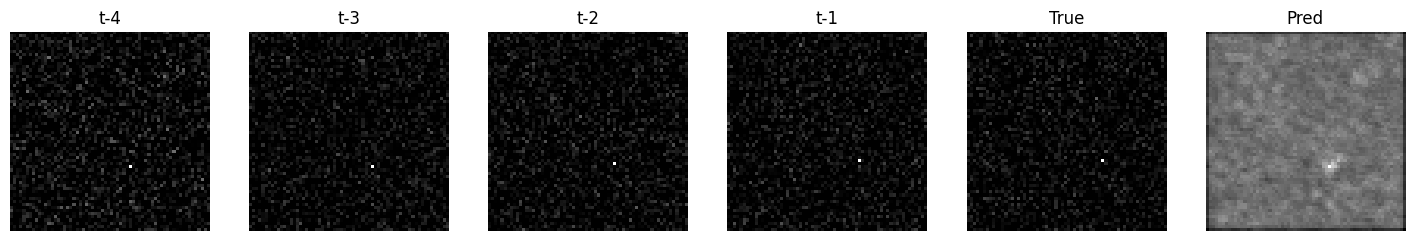

In [ ]:
# Show one prediction
# Visualize the model's prediction compared to the ground truth

@torch.no_grad()
def show_example(i=0):
    """Visualize input frames, true next frame, and predicted next frame"""
    xb, yb = ds[i]
    # Get prediction from model
    pred = model(xb.unsqueeze(0).to(DEVICE)).cpu().squeeze().numpy()
    true = yb.squeeze().numpy()
    # Extract input frames (remove channel dimension)
    hist = xb[:, 0].numpy()
    
    # Create figure with K input frames + true + prediction
    cols = hist.shape[0] + 2
    fig, axs = plt.subplots(1, cols, figsize=(3*cols, 3))
    
    # Show input frames
    for k in range(hist.shape[0]):
        axs[k].imshow(hist[k], cmap="gray")
        axs[k].set_title(f"t-{hist.shape[0]-k}")
        axs[k].axis("off")
    
    # Show true next frame
    axs[-2].imshow(true, cmap="gray")
    axs[-2].set_title("True")
    axs[-2].axis("off")
    
    # Show predicted next frame
    axs[-1].imshow(pred, cmap="gray")
    axs[-1].set_title("Pred")
    axs[-1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Show an example prediction
show_example(5)


## 5) Extensions and Next Steps

### Baseline Improvements
- Predict velocity `frame[t+1]-frame[t]` (change target)
- Try L1/Huber loss and a cosine LR schedule
- Make the split **by time** (first 70% train, last 30% test)
- Replace Conv3D with per-frame Conv2D + LSTM
- Add Sobel edges as extra channels
- Implement early stopping

### Project Requirements
- **Multiple Training Runs**: Run training multiple times (with different seeds) to compute mean ± CI metrics
- **Cross-Experiment Evaluation**: Test if models trained on one experiment generalize to others
- **Aggregation Center Prediction**: Modify to predict center coordinates or probability maps instead of next frame
- **Visualization**: Create overlays showing predicted hotspots/centers on early frames with confidence maps
- **Multiple Models**: Implement at least 3 different modeling approaches:
  - Probabilistic/Bayesian models (denoising, latent parameters)
  - Clustering/EM (mixture models for aggregation zones)
  - Deep learning (ConvLSTM, VAE, etc.)
  - Or other justified approaches

### Metrics to Report
- Spatial accuracy (distance from predicted to true aggregation center)
- Robustness (performance across experiments)
- Error vs. available frames (how early can we predict accurately?)
- Confidence intervals from multiple training runs
